### Título del proyecto: PREDICCIÓN DEL RIESGO DE PAGO TARDÍO PARA EL CUMPLIMIENTO DEL PMP EMPRESARIAL CON ENFOQUE MLOP’S 
#### Autora: Andrea Alexandra Guerra Arguinzones
#### Programa: Máster en Data Analytics
#### Módulo: M9. Nuevas tendencias process mining, MLOP´s, cloud 
#### Fecha de entrega: julio 2025
#### Profesor: Gabriel Valverde Castilla

Este notebook implementa un pipeline completo para predecir si una factura será pagada fuera de plazo, alineado con buenas prácticas de MLOps.

## 1. Carga de datos

In [1]:
import pandas as pd

df = pd.read_csv("dataset.csv")
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0


## 2. Preprocesamiento y creación de variable objetivo

In [2]:
import numpy as np

# Convertir columnas de fecha
df['clear_date'] = pd.to_datetime(df['clear_date'], errors='coerce')
df['due_in_date'] = pd.to_datetime(df['due_in_date'], errors='coerce')
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'], format='%Y%m%d', errors='coerce')

# Crear variable objetivo
df['pagado_fuera_plazo'] = (df['clear_date'] > df['due_in_date']).astype(int)

# Selección de variables
df_modelo = df[['business_code', 'cust_number', 'invoice_currency', 'total_open_amount', 'cust_payment_terms', 'pagado_fuera_plazo']].dropna()
df_modelo.head()

,business_code,cust_number,invoice_currency,total_open_amount,cust_payment_terms,pagado_fuera_plazo
0,U001,0200769623,USD,54273.28,NAH4,1
1,U001,0200980828,USD,79656.60,NAD1,1
2,U001,0200792734,USD,2253.86,NAA8,1
3,CA02,0140105686,CAD,3299.70,CA10,0
4,U001,0200769623,USD,33133.29,NAH4,1


## 3. Entrenamiento y validación del modelo

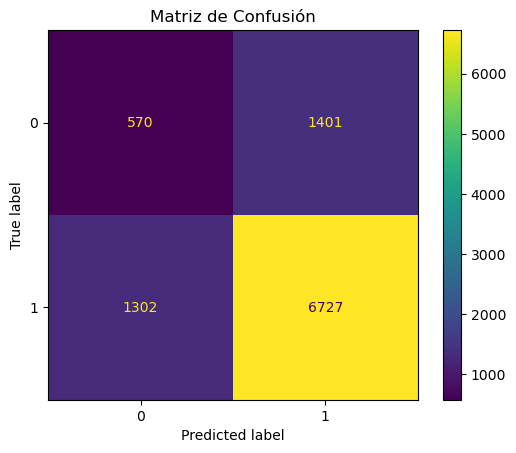

              precision    recall  f1-score   support

           0       0.30      0.29      0.30      1971
           1       0.83      0.84      0.83      8029

    accuracy                           0.73     10000
   macro avg       0.57      0.56      0.56     10000
weighted avg       0.72      0.73      0.73     10000



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Separar variables y etiquetas
X = df_modelo.drop("pagado_fuera_plazo", axis=1)
y = df_modelo["pagado_fuera_plazo"]

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline de preprocesamiento
categorical = ['business_code', 'cust_number', 'invoice_currency', 'cust_payment_terms']
numeric = ['total_open_amount']

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical),
    ("num", SimpleImputer(strategy='mean'), numeric)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluación
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_test, y_pred))

Métricas clave:
- Precision (Clase 1): 0.83 → cuando el modelo predice retraso, acierta el 83% de las veces.
- Recall (Clase 1): 0.84 → detecta el 84% de los pagos efectivamente fuera de plazo.
- F1-Score (Clase 1): 0.83 → buen equilibrio entre precisión y recall.
- Clase 0 (cumplimiento): baja precisión (0.30) y recall (0.29) debido al desbalance de clases.

Accuracy general: 0.73 → el modelo acierta en el 73% de los casos.

Aunque el modelo muestra buen rendimiento global y es eficaz identificando pagos fuera de plazo, presenta limitaciones al clasificar correctamente los pagos que sí cumplen el plazo. Esto puede deberse al desbalance de clases (muchos más ejemplos de clase 1 que de clase 0).


## 4. Registro del modelo con MLflow

In [4]:
import mlflow
import mlflow.sklearn
import joblib

with mlflow.start_run():
    mlflow.log_metric("f1_score", classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"])
    mlflow.sklearn.log_model(pipeline, "modelo_pago_tardio")
    joblib.dump(pipeline, "modelo_pago_tardio.pkl")
    mlflow.log_artifact("modelo_pago_tardio.pkl")

MissingConfigException: Yaml file 'C:\Users\andre\OneDrive\Documentos\IMF\M9\Entrega_final\mlruns\0\meta.yaml' does not exist.

En este paso se registra el modelo entrenado utilizando MLflow, incluyendo la métrica F1-score, el objeto del modelo como pipeline de sklearn y un archivo .pkl como artefacto. 
Esto permite dejar trazabilidad del experimento y facilitar futuras consultas, comparación de versiones o despliegues automatizados.


## 5. Exportación del modelo

El modelo entrenado ha sido exportado como archivo .pkl utilizando joblib.

Este archivo contiene el pipeline completo (preprocesamiento + modelo) y permite reutilizarlo en futuras etapas del proyecto.

En la siguiente fase, este archivo puede ser cargado desde una aplicación FastAPI para exponerlo como servicio de predicción en tiempo real.